# Fake News detection project

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from wordcloud import WordCloud # type: ignore
from collections import Counter
import nltk
from nltk.corpus import stopwords # type: ignore
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
import torch
torch.cuda.is_available()

True

In [1]:
import gensim.downloader as api


In [ ]:
# %pip install pdfplumber
# %pip install nbformat
# %pip pandas==2.2.3
# %pip install matplotlib==3.9.2
# %pip install scipy==1.13.1
# %pip install pyarrow==18.0.0
# %pip install scikit-learn==1.5.2
# %pip install statsmodels==0.14.4
# %pip install seaborn
# %pip install plotly
# %pip install wordcloud
# %pip install nltk
# %pip install tf-keras
# %pip install gensim
# %pip install numpy==1.24.6
# %pip install spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 33.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "pandas==2.2.3"
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.6 MB/s eta 0:00:0000:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.1
    Uninstalling matplotlib-3.10.1:
      Successfully uninstalled matplotlib-3.10.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 81.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pyarrow
    Found existing instal

### Import data

- ISOT Dataset (https://www.kaggle.com/datasets/csmalarkodi/isot-fake-news-dataset?resource=download&select=Fake.csv 
& https://www.kaggle.com/datasets/csmalarkodi/isot-fake-news-dataset/data?select=True.csv)

In [4]:
df_isot_true = pd.read_csv("./data/True.csv", encoding="utf-8")
df_isot_fake = pd.read_csv("./data/Fake.csv", encoding="utf-8")

df_isot_true["label"] = "TRUE"
df_isot_fake["label"] = "FAKE"

# combine both datasets into one
df_isot = pd.concat([df_isot_true, df_isot_fake], ignore_index=True)
df_isot.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",TRUE
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",TRUE
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",TRUE
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",TRUE
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",TRUE


- Fake or Real News Dataset (https://www.kaggle.com/datasets/jillanisofttech/fake-or-real-news/data)

In [5]:
df_fake_or_real = pd.read_csv("./data/fake_or_real_news.csv", encoding='utf-8')
df_fake_or_real.rename(columns={'Unnamed: 0': 'number'}, inplace=True)
df_fake_or_real.head(5)

,number,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


### Data Analysis

- ISOT Dataset

In [6]:
print(f"Dataset shape :{df_isot.shape}")
print(f"There are {len(df_isot.columns)} columns: {df_isot.columns}")
print(df_isot.info())
print(df_isot.isnull().sum())
df_isot.describe(include='all')

Dataset shape :(44898, 5)
There are 5 columns: Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB
None
title      0
text       0
subject    0
date       0
label      0
dtype: int64


,title,text,subject,date,label
count,44898,44898,44898,44898,44898
unique,38729,38646,8,2397,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",FAKE
freq,14,627,11272,182,23481


In [7]:
custom_palette = {
    'FAKE': 'indianred', # '#FF6347',
    'TRUE': 'lightgreen'# '#4CAF50'
}

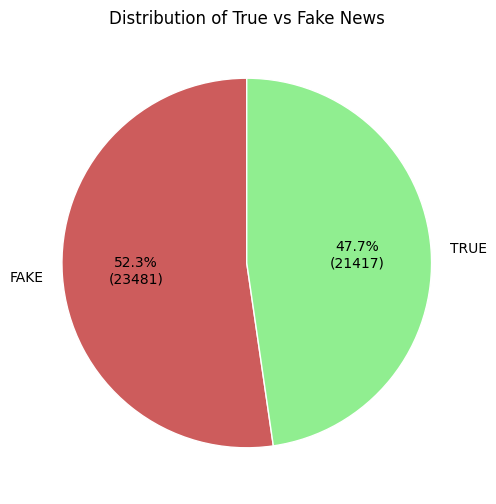

In [8]:
# Pie chart of True vs Fke counts
label_counts = df_isot['label'].value_counts()

# formatting function for labels
def format_label(pct, allvals):
    absolute = int(pct / 100. * sum(allvals))
    return f"{pct:.1f}%\n({absolute})"

plt.figure(figsize=(6, 6))
colors = [custom_palette[label] for label in label_counts.index]
plt.pie(label_counts, labels=label_counts.index, startangle=90, wedgeprops={'edgecolor': 'white'},
        autopct=lambda pct: format_label(pct, label_counts), colors=colors)
plt.title("Distribution of True vs Fake News")
plt.show()

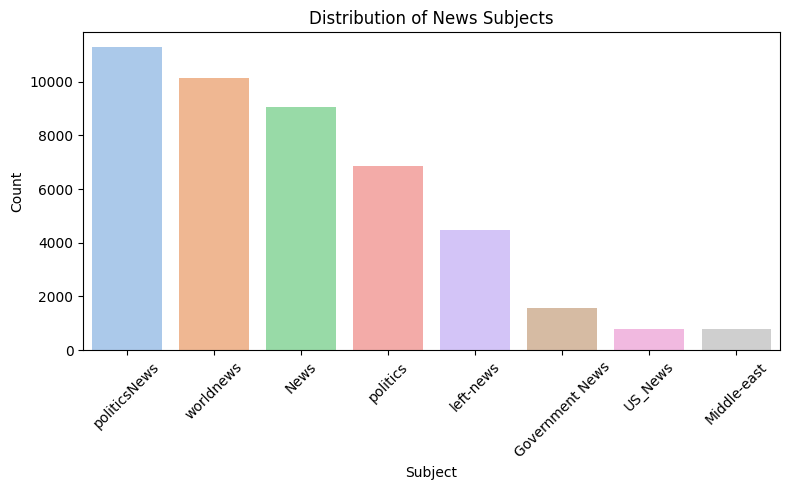

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

In [9]:
# Bar plot of the different subjects of articles
subject_counts = df_isot['subject'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='pastel')
plt.title("Distribution of News Subjects")
plt.xlabel("Subject")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df_isot['subject'].value_counts()

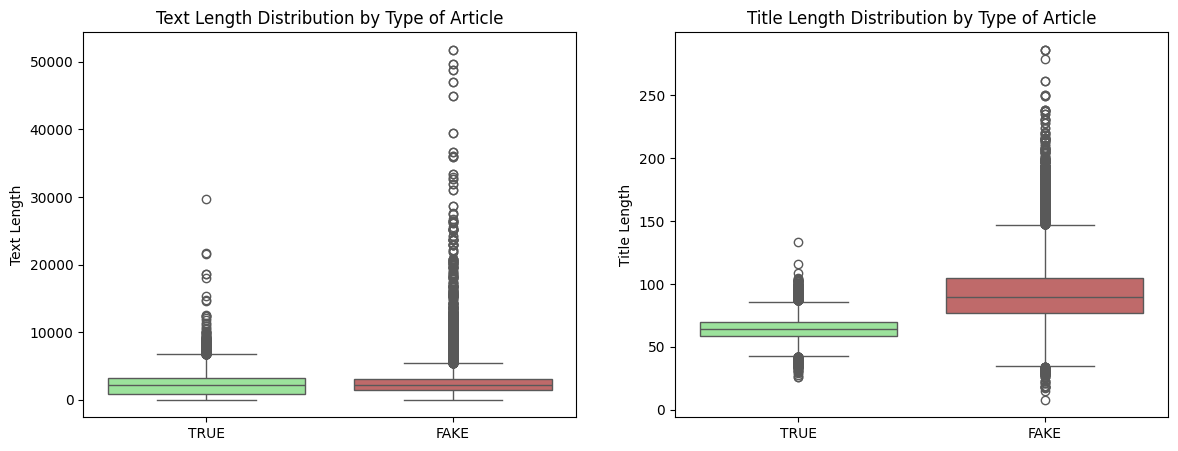

In [10]:
# Box plots for fake vs Truetext length and title length distributions

df_isot['text_length'] = df_isot['text'].apply(len)
df_isot['title_length'] = df_isot['title'].apply(len)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df_isot, x='label', y='text_length', palette=custom_palette, hue='label', ax=axes[0])
axes[0].set_title("Text Length Distribution by Type of Article")
axes[0].set_xlabel("")
axes[0].set_ylabel("Text Length")

sns.boxplot(data=df_isot, x='label', y='title_length', palette=custom_palette, ax=axes[1])
axes[1].set_title("Title Length Distribution by Type of Article")
axes[1].set_ylabel("Title Length")
axes[1].set_xlabel("")

plt.show()

##### Topic exploration
To get a global idea of what topics the speeches treat of
- Word Frequency Analysis and Word Cloud Visualization using word counts and TFIdf_isot Vectorizer


In [11]:
nltk.download('stopwords')

# join all articles' texts for true and fake news :
true_text = ' '.join(df_isot[df_isot.label == 'TRUE']['text'])
fake_text = ' '.join(df_isot[df_isot.label == 'FAKE']['text'])
# combine all articles :
# all_text = ' '.join([true_text, fake_text])

# Normalize to lowercase and count word frequencies
true_words = [word.lower() for word in true_text.split()]
true_word_counts = Counter(true_words)
fake_words = [word.lower() for word in fake_text.split()]
fake_word_counts = Counter(fake_words)

# Filter out common stopwords (in english)
stop_words = set(stopwords.words("english"))
true_filtered_word_counts = {word: count for word, count in true_word_counts.items() if word not in stop_words}
fake_filtered_word_counts = {word: count for word, count in fake_word_counts.items() if word not in stop_words}

[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


To reduce the impact over large tfidf_isot coefficients, we use the log transformation $x \rightarrow log(1+x)$

In [ ]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    min_df=15, # appears in at least 15 docs
    max_df=0.8, # not appear in more than 80% of the doc
    ngram_range=(1, 3),
    token_pattern=r"\b[a-zA-Z]{4,}\b", # removes numbers
    max_features=5000
)

X_ = vectorizer.fit_transform(df_isot_true['text'])
cols = vectorizer.get_feature_names_out()
true_tfidf_isot_matrix = X_.toarray() # convert the TF-Idf_isot matrix as a dense array
true_tfidf_isot = pd.DataFrame(np.log1p(true_tfidf_isot_matrix), columns=cols) #index=df_isot["text"].index,

X_ = vectorizer.fit_transform(df_isot_fake['text'])
cols = vectorizer.get_feature_names_out()
fake_tfidf_isot_matrix = X_.toarray() # convert the TF-Idf_isot matrix as a dense array
fake_tfidf_isot = pd.DataFrame(np.log1p(fake_tfidf_isot_matrix), columns=cols) # index=df_isot["text"].index, 


# Calculate the sum of the TF-Idf_isot scores for each term across all articles
sum_tfidf_isot_scores_true = true_tfidf_isot_matrix.sum(axis=0)
sum_tfidf_isot_scores_fake = fake_tfidf_isot_matrix.sum(axis=0)
# Create a dictionary with words as keys and their total TF-Idf_isot score as values
word_freq_true = dict(zip(cols, sum_tfidf_isot_scores_true))
word_freq_fake = dict(zip(cols, sum_tfidf_isot_scores_fake))

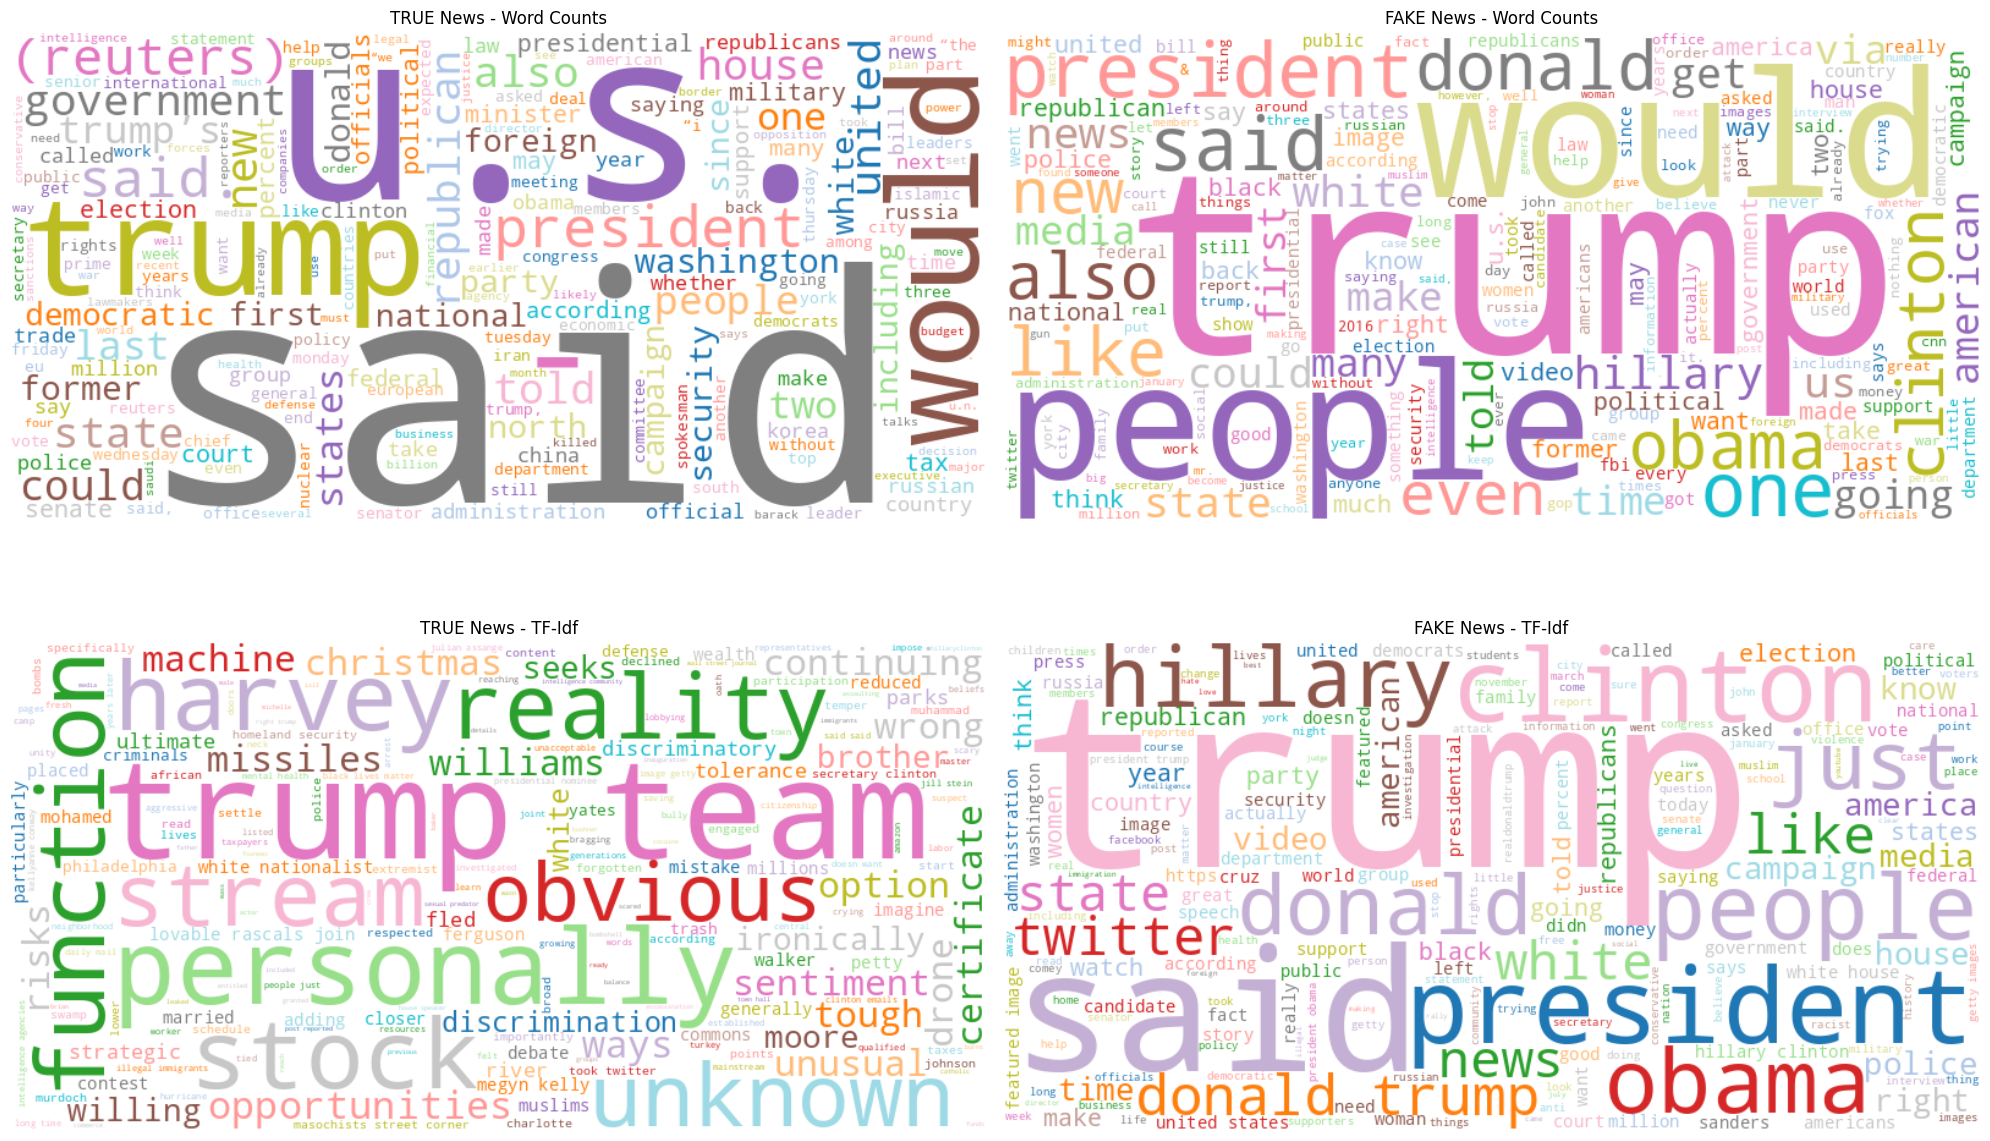

In [ ]:
# Generate word clouds
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# according to word counts
wordcloud_counts_true = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(true_filtered_word_counts)
wordcloud_counts_fake = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(fake_filtered_word_counts)

# according to TF-Idf_isot scores
wordcloud_tfidf_isot_true = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(word_freq_true)
wordcloud_tfidf_isot_fake = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(word_freq_fake)

# plot
axes[0, 0].imshow(wordcloud_counts_true, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('TRUE News - Word Counts')

axes[0, 1].imshow(wordcloud_counts_fake, interpolation='bilinear')
axes[0, 1].axis('off')
axes[0, 1].set_title('FAKE News - Word Counts')

axes[1, 0].imshow(wordcloud_tfidf_isot_true, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title('TRUE News - TF-Idf')

axes[1, 1].imshow(wordcloud_tfidf_isot_fake, interpolation='bilinear')
axes[1, 1].axis('off')
axes[1, 1].set_title('FAKE News - TF-Idf')


plt.subplots_adjust(hspace=1, wspace=30)

plt.tight_layout()
plt.show()

In [ ]:
print("Top 20 REAL words:")
print(list(true_filtered_word_counts.items())[:20])

print("\nTop 20 FAKE words:")
print(list(fake_filtered_word_counts.items())[:20])

Top 20 REAL words:
[('washington', 10785), ('(reuters)', 21239), ('-', 31059), ('head', 2665), ('conservative', 3005), ('republican', 14500), ('faction', 137), ('u.s.', 38276), ('congress,', 791), ('voted', 1396), ('month', 3087), ('huge', 520), ('expansion', 350), ('national', 8085), ('debt', 1281), ('pay', 1937), ('tax', 7388), ('cuts,', 130), ('called', 6013), ('“fiscal', 8)]

Top 20 FAKE words:
[('donald', 16800), ('trump', 65511), ('wish', 550), ('americans', 5091), ('happy', 829), ('new', 13941), ('year', 4167), ('leave', 1376), ('that.', 1585), ('instead,', 699), ('give', 3149), ('shout', 64), ('enemies,', 54), ('haters', 78), ('dishonest', 217), ('fake', 2786), ('news', 12123), ('media.', 570), ('former', 7016), ('reality', 1354)]


- Fake or Real Dataset

In [ ]:
print(f"Dataset shape :{df_fake_or_real.shape}")
print(f"There are {len(df_fake_or_real.columns)} columns: {df_fake_or_real.columns}")
print(df_fake_or_real.info())
print(df_fake_or_real.isnull().sum())
df_fake_or_real.describe(include='all')

Dataset shape :(6335, 4)
There are 4 columns: Index(['number', 'title', 'text', 'label'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   number  6335 non-null   int64 
 1   title   6335 non-null   object
 2   text    6335 non-null   object
 3   label   6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB
None
number    0
title     0
text      0
label     0
dtype: int64


,number,title,text,label
count,6335.000000,6335,6335,6335
unique,NaN,6256,6060,2
top,NaN,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL
freq,NaN,5,58,3171
mean,5280.415627,NaN,NaN,NaN
std,3038.503953,NaN,NaN,NaN
min,2.000000,NaN,NaN,NaN
25%,2674.500000,NaN,NaN,NaN
50%,5271.000000,NaN,NaN,NaN
75%,7901.000000,NaN,NaN,NaN


In [ ]:
# 

### Data Preprocessing

Convert text to lowercase + tokenize + remove stopwords + apply lemmatization

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 82.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
from nltk.tokenize import word_tokenize
import string
import re
import spacy

# Load a spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
nltk.download('punkt')
nltk.download('punkt_tab')

punctuations = set(string.punctuation)

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /home/onyxia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
def clean_text(text):
    # lowercase
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)  # keeps only words and spaces
    # tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations]
    return " ".join(tokens)  # cleaned text back as string

df_isot['clean_text'] = df_isot['text'].progress_apply(clean_text)

100%|██████████| 44898/44898 [01:05<00:00, 685.62it/s] 


In [ ]:
# Lemmatization
def preprocess_text(text):
    doc = nlp(text)  # Convert text to lowercase and tokenize
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)
df_isot['lemma'] = df_isot['clean_text'].progress_apply(lambda doc: preprocess_text(doc).split())
df_isot["lemma_str"] = df_isot["lemma"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
# 24m, 15m with GPU

100%|██████████| 44898/44898 [15:33<00:00, 48.08it/s] 


In [ ]:
df_isot["lemma_str"] = df_isot["lemma"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)

Preprocessing is limited for Bert and Word2Vec models : only text to lowercase

In [ ]:
df_isot['text_BERT'] = df_isot['text'].progress_apply(lambda text: text.lower())

100%|██████████| 44898/44898 [00:00<00:00, 95543.70it/s]


Compute lnguistic cues

In [ ]:
df_isot

,title,text,subject,date,label,text_length,title_length,clean_text,lemma,lemma_str,text_BERT
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",TRUE,4659,64,washington reuters head conservative republica...,"[washington, reuters, head, conservative, repu...",washington reuters head conservative republica...,washington (reuters) - the head of a conservat...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",TRUE,4077,64,washington reuters transgender people allowed ...,"[washington, reuters, transgender, people, all...",washington reuters transgender people allow ti...,washington (reuters) - transgender people will...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",TRUE,2789,60,washington reuters special counsel investigati...,"[washington, reuters, special, counsel, invest...",washington reuters special counsel investigati...,washington (reuters) - the special counsel inv...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",TRUE,2461,59,washington reuters trump campaign adviser geor...,"[washington, reuters, trump, campaign, adviser...",washington reuters trump campaign adviser geor...,washington (reuters) - trump campaign adviser ...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",TRUE,5204,69,seattle washington reuters president donald tr...,"[seattle, washington, reuters, president, dona...",seattle washington reuters president donald tr...,seattle/washington (reuters) - president donal...
...,...,...,...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",FAKE,3237,61,21st century wire says 21wire reported earlier...,"[21st, century, wire, say, 21wire, report, ear...",21st century wire say 21wire report early week...,21st century wire says as 21wire reported earl...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",FAKE,1684,81,21st century wire says familiar theme whenever...,"[21st, century, wire, say, familiar, theme, di...",21st century wire say familiar theme dispute c...,21st century wire says it s a familiar theme. ...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",FAKE,25065,85,patrick henningsen 21st century wireremember o...,"[patrick, henningsen, 21st, century, wireremem...",patrick henningsen 21st century wireremember o...,patrick henningsen 21st century wireremember ...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",FAKE,2685,67,21st century wire says al jazeera america go h...,"[21st, century, wire, say, al, jazeera, americ...",21st century wire say al jazeera america histo...,21st century wire says al jazeera america will...


### Feature Extraction

- Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# create the vectorizer object
bow_vectorizer = CountVectorizer(max_features=1000)

# Fit and transform the corpus
X_bow = bow_vectorizer.fit_transform(df_isot["lemma_str"])

print("Vocabulary:", bow_vectorizer.get_feature_names_out())

Vocabulary: ['000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '2012'
 '2013' '2014' '2015' '2016' '2017' '21st' '21wire' '22' '24' '25' '30'
 '50' 'able' 'abortion' 'absolutely' 'abuse' 'accept' 'access' 'accord'
 'account' 'accusation' 'accuse' 'act' 'action' 'activist' 'activity'
 'actually' 'ad' 'add' 'address' 'administration' 'admit' 'adviser'
 'advocate' 'affect' 'afghanistan' 'african' 'agency' 'agenda' 'agent'
 'ago' 'agree' 'agreement' 'ahead' 'aid' 'aide' 'aim' 'air' 'al'
 'allegation' 'allege' 'allow' 'ally' 'ambassador' 'amendment' 'america'
 'american' 'americans' 'announce' 'answer' 'anti' 'apparently' 'appeal'
 'appear' 'approach' 'approve' 'april' 'arabia' 'area' 'argue' 'arm'
 'armed' 'army' 'arrest' 'article' 'ask' 'assault' 'associate' 'attack'
 'attempt' 'attend' 'attention' 'attorney' 'august' 'authority' 'avoid'
 'away' 'back' 'bad' 'ban' 'bank' 'bar' 'barack' 'base' 'battle' 'bear'
 'begin' 'behavior' 'beijing' 'believe' 'benefit' 'bernie' 'big'

- TFIDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df_isot["lemma_str"])

print("Vocabulary:", tfidf_vectorizer.get_feature_names_out())

Vocabulary: ['000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '2012'
 '2013' '2014' '2015' '2016' '2017' '21st' '21wire' '22' '24' '25' '30'
 '50' 'able' 'abortion' 'absolutely' 'abuse' 'accept' 'access' 'accord'
 'account' 'accusation' 'accuse' 'act' 'action' 'activist' 'activity'
 'actually' 'ad' 'add' 'address' 'administration' 'admit' 'adviser'
 'advocate' 'affect' 'afghanistan' 'african' 'agency' 'agenda' 'agent'
 'ago' 'agree' 'agreement' 'ahead' 'aid' 'aide' 'aim' 'air' 'al'
 'allegation' 'allege' 'allow' 'ally' 'ambassador' 'amendment' 'america'
 'american' 'americans' 'announce' 'answer' 'anti' 'apparently' 'appeal'
 'appear' 'approach' 'approve' 'april' 'arabia' 'area' 'argue' 'arm'
 'armed' 'army' 'arrest' 'article' 'ask' 'assault' 'associate' 'attack'
 'attempt' 'attend' 'attention' 'attorney' 'august' 'authority' 'avoid'
 'away' 'back' 'bad' 'ban' 'bank' 'bar' 'barack' 'base' 'battle' 'bear'
 'begin' 'behavior' 'beijing' 'believe' 'benefit' 'bernie' 'big'

- Word2Vec

The resulting document vector is the mean of the word vectors for each word in the document. This is to aggregate word-level embeddings into document-level embeddings.

In [ ]:
# Load the pretrained Word2Vec model
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')
#11m

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
df_isot


,title,text,subject,date,label,text_length,title_length,clean_text,lemma,lemma_str,text_BERT,word2vec
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",TRUE,4659,64,washington reuters head conservative republica...,"[washington, reuters, head, conservative, repu...",washington reuters head conservative republica...,washington (reuters) - the head of a conservat...,"[0.023500377, 0.013002853, 0.026691178, 0.1353..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",TRUE,4077,64,washington reuters transgender people allowed ...,"[washington, reuters, transgender, people, all...",washington reuters transgender people allow ti...,washington (reuters) - transgender people will...,"[-0.04800965, 0.025547517, 0.040918488, 0.0836..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",TRUE,2789,60,washington reuters special counsel investigati...,"[washington, reuters, special, counsel, invest...",washington reuters special counsel investigati...,washington (reuters) - the special counsel inv...,"[-0.029175265, 0.018063052, 0.027997082, 0.058..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",TRUE,2461,59,washington reuters trump campaign adviser geor...,"[washington, reuters, trump, campaign, adviser...",washington reuters trump campaign adviser geor...,washington (reuters) - trump campaign adviser ...,"[-0.045700837, 0.0043110657, 0.020889817, 0.03..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",TRUE,5204,69,seattle washington reuters president donald tr...,"[seattle, washington, reuters, president, dona...",seattle washington reuters president donald tr...,seattle/washington (reuters) - president donal...,"[0.00990533, 0.009627542, -0.029523628, 0.0834..."
...,...,...,...,...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",FAKE,3237,61,21st century wire says 21wire reported earlier...,"[21st, century, wire, say, 21wire, report, ear...",21st century wire say 21wire report early week...,21st century wire says as 21wire reported earl...,"[-0.009837789, 0.058016635, 0.025460219, 0.102..."
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",FAKE,1684,81,21st century wire says familiar theme whenever...,"[21st, century, wire, say, familiar, theme, di...",21st century wire say familiar theme dispute c...,21st century wire says it s a familiar theme. ...,"[0.023314217, 0.015318763, -0.017812919, 0.093..."
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",FAKE,25065,85,patrick henningsen 21st century wireremember o...,"[patrick, henningsen, 21st, century, wireremem...",patrick henningsen 21st century wireremember o...,patrick henningsen 21st century wireremember ...,"[0.0071073812, 0.025381163, 0.018495409, 0.088..."
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",FAKE,2685,67,21st century wire says al jazeera america go h...,"[21st, century, wire, say, al, jazeera, americ...",21st century wire say al jazeera america histo...,21st century wire says al jazeera america will...,"[0.027729725, 0.033886828, -0.011203512, 0.102..."


In [ ]:
# Define a function to convert a document to a vector by averaging the embeddings of its words
def get_document_vector(doc, model):
    tokens = doc.split()
    # get vectors for each word in the document
    word_vectors = []
    for word in tokens:
        if word in model.key_to_index:
            word_vectors.append(model[word])
    
    # if no valid word vectors, return a zero-vector
    if not word_vectors:
        return np.zeros(model.vector_size)
    
    # average the word vectors
    return np.mean(word_vectors, axis=0)

df_isot['word2vec'] = df_isot['text_BERT'].apply(lambda x: get_document_vector(x, wv))
df_isot['word2vec'].head()

0    [0.03163108, 0.02999982, 0.04029426, 0.1054190...
1    [-0.017906586, 0.044353463, 0.059727278, 0.075...
2    [0.016446222, 0.04384317, 0.045156073, 0.06268...
3    [0.0075391564, 0.036518387, 0.04778956, 0.0296...
4    [0.02672058, 0.02246702, 0.013854568, 0.066357...
Name: word2vec, dtype: object

- BERT features

In [ ]:
# from tf_transformers.models import BertModel
from transformers import BertTokenizer, BertModel
import torch

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move input tensors to GPU
    with torch.no_grad():
        outputs = model(**inputs)
    # Mean pooling of token embeddings
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # Move back to CPU before converting to numpy
    return embeddings

df_isot["bert_embedding"] = df_isot["text_BERT"].progress_apply(get_bert_embedding)

  5%|▍         | 2108/44898 [46:35<21:17:14,  1.79s/it]

- linguistic cues (34 linguistic features :‘Linguistic Dimensions’ and
‘Punctuation Cues’)

In [ ]:
import syllables
from nltk.tokenize import sent_tokenize


In [ ]:
# Word Count
df_isot['word_count'] = df_isot['text'].apply(lambda doc: len(word_tokenize(doc)))

# Syllables count
df_isot['syl_count'] = df_isot['text'].apply(
    lambda doc: sum(syllables.estimate(word) for word in doc.split())
)

# Sentence Count
df_isot['sentence_count'] = df_isot['text'].apply(lambda doc: len(sent_tokenize(doc)))

# Word/Sent
df_isot['avg_word_sent'] = df_isot['text'].apply(
    lambda doc: sum(len(word_tokenize(sentence)) for sentence in sent_tokenize(doc)) / len(sent_tokenize(doc)) 
    if len(sent_tokenize(doc)) > 0 else 0
)

# Long Words Count
df_isot['long_word_count'] = df_isot['text'].apply(
    lambda doc: sum(1 for word in word_tokenize(doc) if len(word) > 6)
)

# All Caps Count
df_isot['all_caps_count'] = df_isot['text'].apply(
    lambda doc: sum(1 for word in word_tokenize(doc) if word.isupper())
)

# Unique Words Count
df_isot['unique_word_count'] = df_isot['text'].apply(
    lambda doc: len(set(word_tokenize(doc.lower())))
)

# Personal Pronouns %
df_isot['perso_pronouns'] = df_isot['text'].apply(
    lambda doc: len()/len(word_tokenize(doc))
)

In [ ]:
# import os
# import wget
# import gzip
# import shutil

# gn_vec_path = "GoogleNews-vectors-negative300.bin"
# if not os.path.exists("GoogleNews-vectors-negative300.bin"):
#     #Downloading the reqired model
#     if not os.path.exists("GoogleNews-vectors-negative300.bin.gz"):
#         wget.download("https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g")
#         gn_vec_zip_path = "GoogleNews-vectors-negative300.bin.gz"
#     #Extracting the required model
#     with gzip.open(gn_vec_zip_path, 'rb') as f_in:
#         with open(gn_vec_path, 'wb') as f_out:
#             shutil.copyfileobj(f_in, f_out)

# print(f"Model at {gn_vec_path}")

ValueError: not enough values to unpack (expected 2, got 1)